In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage.io
import os 
import glob
from PIL import Image
from sklearn.utils import shuffle, resample
from sklearn import metrics
from sklearn.model_selection import train_test_split
from tensorflow import keras
from skimage.io import imread, imshow
from skimage.transform import resize
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.applications import ResNet50, DenseNet121,EfficientNetB1
from tensorflow.keras.utils import to_categorical
from keras import optimizers
from tensorflow.keras.optimizers import Adam, SGD
from keras.applications.nasnet import NASNetLarge, NASNetMobile
from keras.callbacks import Callback,ModelCheckpoint,ReduceLROnPlateau
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from keras.utils import to_categorical
from keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout,Input, UpSampling2D, GlobalAveragePooling2D,concatenate,Conv2DTranspose
from keras.models import Sequential,load_model,Model
import random
import warnings

warnings.filterwarnings('ignore')

In [61]:
path = '/kaggle/input/severstal-steel-defect-detection'
train_df = pd.read_csv('/kaggle/input/severstal-steel-defect-detection/train.csv')
data_folder = '/kaggle/input/severstal-steel-defect-detection/train_images'
test_folder = '/kaggle/input/severstal-steel-defect-detection/test_images'
input_shape = (128,128)

In [62]:
df1 = train_df[train_df.ClassId == 1]
df2 = train_df[train_df.ClassId == 2]
df3 = train_df[train_df.ClassId == 3]
df4 = train_df[train_df.ClassId == 4]
print(df1.shape, df2.shape, df3.shape, df4.shape)

(897, 3) (247, 3) (5150, 3) (801, 3)


In [63]:
df3_undersampled = resample(df3, replace=False, n_samples=1500, random_state=42)  
df1_oversampled = resample(df1, replace=True, n_samples=1500, random_state=42)  
df2_oversampled = resample(df2, replace=True, n_samples=1500, random_state=42)  
df4_oversampled = resample(df4, replace=True, n_samples=1500, random_state=42)  

balanced_data = pd.concat([df1_oversampled, df2_oversampled, df3_undersampled, df4_oversampled])
balanced_data = balanced_data.sample(frac=1, random_state=42)
balanced_data

,ImageId,ClassId,EncodedPixels
2399,599251689.jpg,2,203265 128 203521 2688
6433,e7aff0392.jpg,3,377809 12 378063 26 378318 27 378572 29 378827...
2946,6c62c50e3.jpg,1,8844 5 9090 15 9341 20 9597 20 9853 20 10109 2...
6481,e97006670.jpg,2,243457 151 243713 151 243969 152 244225 152 24...
4659,a9914e83b.jpg,4,80985 3 81237 9 81490 14 81742 20 81995 25 822...
...,...,...,...
5552,c802d3e11.jpg,3,4845 5 5101 14 5357 19 5613 19 5869 19 6125 19...
3002,6e71531ae.jpg,4,113394 2 113647 7 113900 11 114153 16 114406 2...
3652,84e51db1c.jpg,4,126369 6 126623 16 126877 27 126965 3 126993 6...
6627,ee83f88d5.jpg,4,340436 5 340686 13 340936 22 341186 30 341438 ...


In [64]:
def rle_decode(mask_rle: str = '', shape: tuple = (256, 1600)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

def make_mask(balanced_data: pd.DataFrame, image_name: str='img.jpg', shape: tuple = (256, 1600)):
    encoded_masks = balanced_data.loc[balanced_data['ImageId'] == image_name, 'EncodedPixels']
    masks = np.zeros((shape[0], shape[1]), dtype=np.float32)
    for idx, label in enumerate(encoded_masks.values):
        if label is not np.nan:
            mask = rle_decode(label)
            masks[:, :] = mask
    return masks

def get_img(x, folder: str='Train_images'):
    image_path = os.path.join(data_folder, x)
    print(image_path)
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [65]:
test_list = []
for file in os.listdir(test_folder):
    imgpath = os.path.join(test_folder, file)
    imgtest = cv2.imread(imgpath)
    imgtest = cv2.resize(imgtest, input_shape)
    test_list.append(imgtest)

In [66]:
img_list = balanced_data["ImageId"].tolist()
label_list = balanced_data["ClassId"].tolist()
img_list[0:5], label_list[0:5]

(['599251689.jpg',
  'e7aff0392.jpg',
  '6c62c50e3.jpg',
  'e97006670.jpg',
  'a9914e83b.jpg'],
 [2, 3, 1, 2, 4])

In [67]:
%%capture
image_list = []
mask_list = []
for img in img_list:
    image = get_img(img)
    image = cv2.resize(image, input_shape)
    mask = make_mask(balanced_data, img)
    mask = cv2.resize(mask, input_shape)
    image_list.append(image)
    mask_list.append(mask)

In [82]:
X = np.array(image_list)
y = np.array(mask_list)
encoded = LabelEncoder()
z=encoded.fit_transform(label_list)
z=to_categorical(z)
print(X.shape, y.shape, z.shape)

(6000, 128, 128, 3) (6000, 128, 128) (6000, 4)


In [83]:
X_train, X_val, y_train, y_val, z_train, z_val = train_test_split(X, y, z, test_size=0.2, shuffle=True)

In [84]:
def unet(input_shape): 
    inputs = tf.keras.layers.Input(input_shape)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    b1 = tf.keras.layers.BatchNormalization()(c1)
    r1 = tf.keras.layers.ReLU()(b1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(r1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    b2 = tf.keras.layers.BatchNormalization()(c2)
    r2 = tf.keras.layers.ReLU()(b2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(r2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    b3 = tf.keras.layers.BatchNormalization()(c3)
    r3 = tf.keras.layers.ReLU()(b3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(r3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    b4 = tf.keras.layers.BatchNormalization()(c4)
    r4 = tf.keras.layers.ReLU()(b4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(r4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    b5 = tf.keras.layers.BatchNormalization()(c5)
    r5 = tf.keras.layers.ReLU()(b5)
    c5 = tf.keras.layers.Dropout(0.3)(r5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.BatchNormalization()(u6)
    u6 = tf.keras.layers.ReLU()(u6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(u6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.BatchNormalization()(u7)
    u7 = tf.keras.layers.ReLU()(u7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.BatchNormalization()(u8)
    u8 = tf.keras.layers.ReLU()(u8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(u8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    u9 = tf.keras.layers.BatchNormalization()(u9)
    u9 = tf.keras.layers.ReLU()(u9)

    outputs = tf.keras.layers.Conv2D(1, 1, padding='same', activation='sigmoid')(u9)
    model = tf.keras.models.Model(inputs, outputs)
    return model

In [89]:
model = unet((128, 128, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 5,verbose = 1,factor = 0.50, min_lr = 1e-10)

In [93]:
history = model.fit(X_train, y_train, epochs = 50, batch_size=32, validation_data=(X_val, y_val), callbacks=[lrd])

Epoch 1/50
150/150 [==============================] - 7s 46ms/step - loss: 0.0328 - accuracy: 0.9863 - val_loss: 0.0830 - val_accuracy: 0.9768 - lr: 1.2500e-04
Epoch 2/50
150/150 [==============================] - 7s 44ms/step - loss: 0.0327 - accuracy: 0.9864 - val_loss: 0.0818 - val_accuracy: 0.9769 - lr: 1.2500e-04
Epoch 3/50
150/150 [==============================] - 7s 44ms/step - loss: 0.0325 - accuracy: 0.9864 - val_loss: 0.0828 - val_accuracy: 0.9767 - lr: 1.2500e-04
Epoch 4/50
150/150 [==============================] - 7s 44ms/step - loss: 0.0322 - accuracy: 0.9865 - val_loss: 0.0827 - val_accuracy: 0.9770 - lr: 1.2500e-04
Epoch 5/50
150/150 [==============================] - 7s 44ms/step - loss: 0.0320 - accuracy: 0.9866 - val_loss: 0.0834 - val_accuracy: 0.9769 - lr: 1.2500e-04
Epoch 6/50
150/150 [==============================] - 7s 44ms/step - loss: 0.0321 - accuracy: 0.9865 - val_loss: 0.0836 - val_accuracy: 0.9771 - lr: 1.2500e-04
Epoch 7/50
149/150 [====================

1/1 [==============================] - 0s 24ms/step


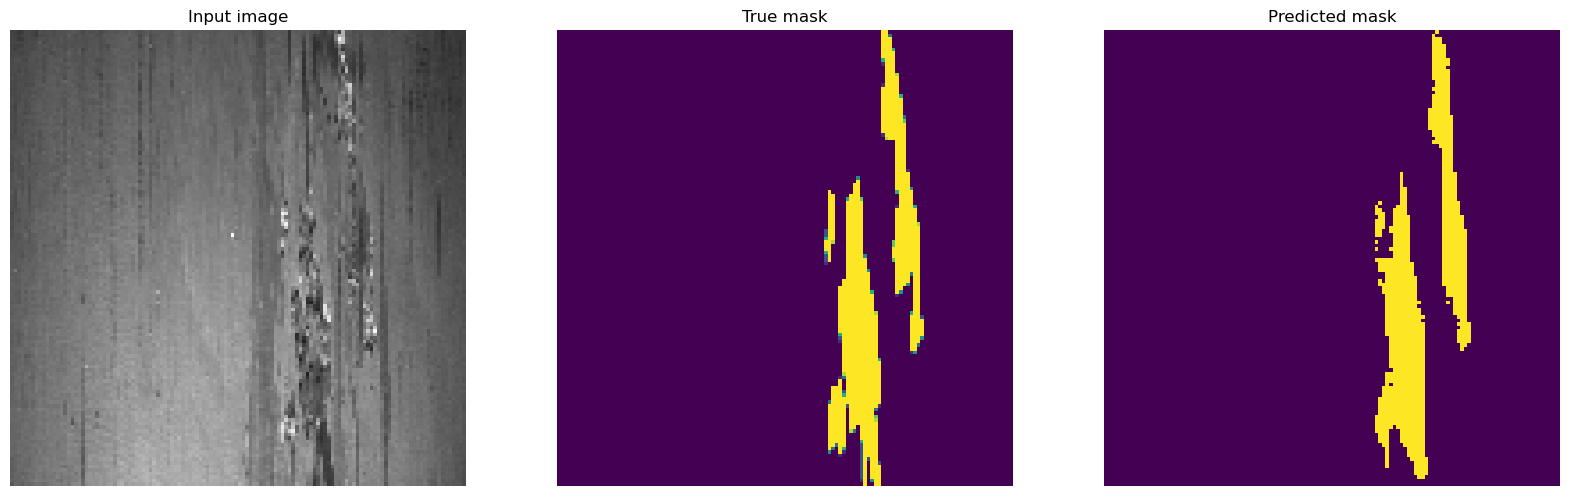

In [94]:
def display(display_list):
    plt.figure(figsize=(20, 20))
    title = ['Input image', 'True mask', 'Predicted mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()

i = random.randint(0, len(X_val) - 1)
sample_image = X_val[i]
sample_mask = y_val[i]
prediction = model.predict(sample_image[np.newaxis, ...])[0]
predicted_mask = (prediction > 0.5).astype(np.uint8)
display([sample_image, sample_mask, predicted_mask])

In [98]:
prediction = model.predict(sample_image[np.newaxis, ...])[0]
print(tf.reduce_max(prediction))

1/1 [==============================] - 0s 24ms/step
tf.Tensor(0.9993919, shape=(), dtype=float32)


Сеть архитектуры U-Net хорошо справилась с задачей сегментации дефектов, показав высокую точность на тестовой выборке и случайном снимке, что видно на картинке.